In [35]:
import io 
import numpy as np 
import random

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import re

# Import Dataset 

The dataset 'divina_commedia.txt' is imported, containing the text of Dante's Divine Comedy. The file includes additional lines that are not part of the original text but provide information about the author.

In [36]:
print('Opening file...')
path = "divina_commedia.txt"
with io.open(path, encoding='utf-8') as file:
    text = file.read().lower()

print("text length", len(text))
print()
print('\n\n\n\n\n', '***** first 1000 characters *****', '\n\n\n\n\n')
text[0:1000]

Opening file...
text length 558240






 ***** first 1000 characters ***** 







"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

In [37]:
# Remove information about the author
text = re.sub(r"(e-text courtesy progetto manuzio)", "", text, flags=re.DOTALL)

print("text length", len(text))
print()
print('\n\n\n\n\n', '***** first 1000 characters *****', '\n\n\n\n\n')
text[0:1000]

text length 558176






 ***** first 1000 characters ***** 







"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

# Divide the sequences into training, validation and test sets

## Dividing the sequences into training, validation and test sets (**unbalanced approach**)

The dataset was divided into *canti*, with each canto randomly assigned to one of the sets: **training**, **validation** or **test**. Each canto belongs to only one set, and the final distribution of the dataset is: 70% for training, 20% for validation and 10% for testing.

Since the *canti* are assigned randomly, the results may vary, and the division might not be perfectly balanced.

For this initial model, the same architecture used during the lab was implemented.

### Preprocessing of unbalanced data

During the data preprocessing phase, the text is divided into individual *canti*, with unnecessary titles removed to retain only the 100 *canti* from the Divine Comedy

In [38]:
canti = re.split(r'(?<=\n)(inferno|purgatorio|paradiso):\s*canto\s*[ivxlcdm]+\n*', text)

canti = [canto.strip() for canto in canti if canto.strip() and canto.lower() not in ['inferno', 'purgatorio', 'paradiso']]

# The first element of 'cantos', namely 'inferno', is removed from the list to obtain a list containing only the cantos. 
if canti[0].lower() in ['inferno', 'purgatorio', 'paradiso']:
    canti = canti[1:]

print("Number of canti: ", len(canti))

# Print second canto
print(canti[1]) 

Number of canti:  100
lo giorno se n'andava, e l'aere bruno
  toglieva li animai che sono in terra
  da le fatiche loro; e io sol uno

m'apparecchiava a sostener la guerra
  si` del cammino e si` de la pietate,
  che ritrarra` la mente che non erra.

o muse, o alto ingegno, or m'aiutate;
  o mente che scrivesti cio` ch'io vidi,
  qui si parra` la tua nobilitate.

io cominciai: <<poeta che mi guidi,
  guarda la mia virtu` s'ell'e` possente,
  prima ch'a l'alto passo tu mi fidi.

tu dici che di silvio il parente,
  corruttibile ancora, ad immortale
  secolo ando`, e fu sensibilmente.

pero`, se l'avversario d'ogne male
  cortese i fu, pensando l'alto effetto
  ch'uscir dovea di lui e 'l chi e 'l quale,

non pare indegno ad omo d'intelletto;
  ch'e' fu de l'alma roma e di suo impero
  ne l'empireo ciel per padre eletto:

la quale e 'l quale, a voler dir lo vero,
  fu stabilita per lo loco santo
  u' siede il successor del maggior piero.

per quest'andata onde li dai tu vanto,
  intese cos

In [39]:
chars = sorted(list(set(text)))
print('total chars: ', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(char_indices)
print(indices_char)

total chars:  40
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}


### Definition of functions

In this section, the functions used for completing the assignment are defined

In [131]:
# This function divides the modified text into fixed-length sequences and associates the next character with each sequence

def generete_sequences(text, maxlen, step):
    sentences = []
    next_chars = []

    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    
    return sentences, next_chars

In [40]:
# The function converts the character sequences and target characters into one-hot representations

def encode_sequences(sentences, next_chars, maxlen, chars, char_indices):
    x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(sentences), len(chars)), dtype=bool)

    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

    return x, y

In [42]:
# Print graphs of loss and accuracy

import matplotlib.pyplot as plt

def plot_performance(history):
    flg, ax = plt.subplots(1,2)
    flg.tight_layout()
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss')
    ax[0].plot(train_loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].legend()
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].plot(train_acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].legend()

    plt.show()

In [43]:
import sys

def testAfterEpoch(epoch, _, maxlen, text, model):
    print()
    print()
    print('***** Epoch: %d *****' % (epoch+1))
    start_index = random.randint(0, len(text)- maxlen - 1)

    generated = ''
    sentence = text[start_index : start_index + maxlen]
    generated = generated + sentence

    print('***** starting sentence *****') 
    print(sentence)
    print('*****************************')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1
        
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [44]:
# The code randomly splits the list "canti" into three subsets: training set, validation set, and test set, with proportions of 70%, 20% and 10% of total, resepctively

random.shuffle(canti)

train_size = int(0.7 * len(canti))
val_size = int(0.2 * len(canti))
test_size = len(canti) - train_size - val_size

train_canti = canti[:train_size]
val_canti = canti[train_size:train_size + val_size]
test_canti = canti[train_size + val_size:]

print(f"Training set: {len(train_canti)} canti")
print(f"Validation set: {len(val_canti)} canti")
print(f"Test set: {len(test_canti)} canti")

Training set: 70 canti
Validation set: 20 canti
Test set: 10 canti


## Model 1

In this model, the same architecture used during the lab has been applied. The main modification is that the model is trained on a text divided into *training*, *validation*, and *test* sets. Additionally, during training, *accuracy* is also monitored

In [45]:
maxlen = 30 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  128555

  giu` nel secondo, che men l
o


In [46]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

In [47]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (128555, 30, 40)
y_train shape: (128555, 40)
x_val shape: (37821, 30, 40)
y_val shape: (37821, 40)
x_test shape: (18765, 30, 40)
y_test shape: (18765, 40)


In [48]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
text_canti = ''.join(train_canti)

print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_canti,
        model
        )
    )

In [50]:
history = model.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback], 
        )

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1708 - loss: 3.0630

***** Epoch: 1 *****
***** starting sentence *****
i si dice,
  di qua che dire e
*****************************
i si dice,
  di qua che dire e di si si se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se 
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 858ms/step - accuracy: 0.1715 - loss: 3.0585 - val_accuracy: 0.2936 - val_loss: 2.3692
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3088 - loss: 2.2679

***** Epoch: 2 *****
***** starting sentence *****
erso questa rivera,
  tanto ch
*****************************
erso questa rivera,
  tanto che l'alla che l'alla che

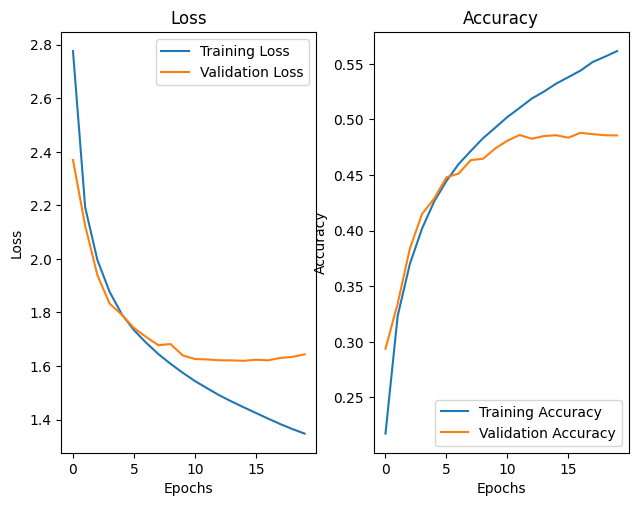

In [51]:
plot_performance(history)

The **training loss** consistently decreases as the epochs progress, indicating that the model is learning from the training data. The **validation loss** initially decreases but stabilizes around 1.6, with a slight increase towards the end. This behavior could be a sign of overfitting, where the model is learning the training data too well and struggles to generalize to the validation data.

In the **accuracy** graph, the **training accuracy** curve steadily increases, surpassing 55%. On the other hand, the **validation accuracy** increases initially but stabilizes around 48% after a few epochs.

In both graphs, there is a growing gap between the training and validation curves after several epochs, suggesting that the model may be starting to overfit the training data

In [52]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6491461992263794
Test accuracy 0.4870237112045288


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.6 and the test loss is very similar. Additionally, the validation accuracy stabilizes around 48%, which is perfectly aligned with the test accuracy.

From these results, it can be concluded that the model's performance is not optimal, as the accuracy is relatively low. Furthermore, the graphs clearly show signs of overfitting

## Dividing the sequence into training, validation and test sets (**balanced approach**)

**da scrivere**

### Preprocessing of balanced data

In [53]:
# Pre processing dei dati andando a dividere i canti

cantiche = re.split(r'\n(inferno|purgatorio|paradiso)\n', text)

cantiche = [canto.strip() for canto in cantiche if canto.strip() and canto.lower() not in ['inferno', 'purgatorio', 'paradiso']]

print(cantiche)
print("Total cantiche: ", len(cantiche))
print(cantiche[1])

['inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che\' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant\'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch\'i\' vi trovai,\n  diro` de l\'altre cose ch\'i\' v\'ho scorte.\n\nio non so ben ridir com\'i\' v\'intrai,\n  tant\'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch\'i\' fui al pie` d\'un colle giunto,\n  la` dove terminava quella valle\n  che m\'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de\' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m\'era durata\n  la notte ch\'i\' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l\'acqua perigliosa e guata,\

In [54]:
# Division of INFERNO
canti_inferno = re.split(r'(?<=\n)(inferno):\s*canto\s*[ivxlcdm]+\n*', cantiche[0])

canti_inferno = [canto.strip() for canto in canti_inferno if canto.strip() and canto.lower() not in ['inferno']]

# The first element of 'canti', namely 'Inferno', is removed from the list to obtain a list containing only the canti
if canti_inferno[0].lower() in ['inferno', 'purgatorio', 'paradiso']:
    canti_inferno = canti_inferno[1:]

print("Number of canti: ", len(canti_inferno))

train_size_inferno = int(0.7 * len(canti_inferno))
val_size_inferno = int(0.2 * len(canti_inferno))
test_size_inferno = len(canti_inferno) - train_size_inferno - val_size_inferno

train_inferno = canti_inferno[:train_size_inferno]
val_inferno = canti_inferno[train_size_inferno:train_size_inferno + val_size_inferno]
test_inferno = canti_inferno[train_size_inferno + val_size_inferno:]

print(f"Training set: {len(train_inferno)} canti")
print(f"Validation set: {len(val_inferno)} canti")
print(f"Test set: {len(test_inferno)} canti")

Number of canti:  34
Training set: 23 canti
Validation set: 6 canti
Test set: 5 canti


In [55]:
# Division of PURGATORIO
canti_purgatorio = re.split(r'(?<=\n)(purgatorio):\s*canto\s*[ivxlcdm]+\n*', cantiche[1])

canti_purgatorio = [canto.strip() for canto in canti_purgatorio if canto.strip() and canto.lower() not in ['purgatorio']]

# The first element of 'canti', namely 'Inferno', is removed from the list to obtain a list containing only the canti 
if canti_purgatorio[0].lower() in ['purgatorio']:
    canti_purgatorio = canti_purgatorio[1:]

print("Number of canti: ", len(canti_purgatorio))

train_size_purgatorio = int(0.7 * len(canti_purgatorio))
val_size_purgatorio = int(0.2 * len(canti_purgatorio))
test_size_purgatorio = len(canti_purgatorio) - train_size_purgatorio - val_size_purgatorio

train_purgatorio = canti_purgatorio[:train_size_purgatorio]
val_purgatorio = canti_purgatorio[train_size_purgatorio:train_size_purgatorio + val_size_purgatorio]
test_purgatorio = canti_purgatorio[train_size_purgatorio + val_size_purgatorio:]

print(f"Training set: {len(train_purgatorio)} canti")
print(f"Validation set: {len(val_purgatorio)} canti")
print(f"Test set: {len(test_purgatorio)} canti")

Number of canti:  33
Training set: 23 canti
Validation set: 6 canti
Test set: 4 canti


In [56]:
# Division of PARADISO
canti_paradiso = re.split(r'(?<=\n)(paradiso):\s*canto\s*[ivxlcdm]+\n*', cantiche[2])

canti_paradiso = [canto.strip() for canto in canti_paradiso if canto.strip() and canto.lower() not in ['paradiso']]

# The first element of 'canti', namely 'Paradiso', is removed from the list to obtain a list containing only the canti 
if canti_paradiso[0].lower() in ['paradiso']:
    canti_paradiso = canti_paradiso[1:]

print("Number of canti: ", len(canti_paradiso))

train_size_paradiso = int(0.7 * len(canti_paradiso))
val_size_paradiso = int(0.2 * len(canti_paradiso))
test_size_paradiso = len(canti_paradiso) - train_size_paradiso - val_size_paradiso

train_paradiso = canti_paradiso[:train_size_paradiso]
val_paradiso = canti_paradiso[train_size_paradiso:train_size_paradiso + val_size_paradiso]
test_paradiso = canti_paradiso[train_size_paradiso + val_size_paradiso:]

print(f"Training set: {len(train_paradiso)} canti")
print(f"Validation set: {len(val_paradiso)} canti")
print(f"Test set: {len(test_paradiso)} canti")

Number of canti:  33
Training set: 23 canti
Validation set: 6 canti
Test set: 4 canti


In [57]:
# Uniamo i canti suddivisi per ciascuna cantica nei rispettivi set finali
train_canti = train_inferno + train_purgatorio + train_paradiso
val_canti = val_inferno + val_purgatorio + val_paradiso
test_canti = test_inferno + test_purgatorio + test_paradiso

# Stampa la lunghezza dei set
print(f"Training set: {len(train_canti)} canti")
print(f"Validation set: {len(val_canti)} canti")
print(f"Test set: {len(test_canti)} canti")

Training set: 69 canti
Validation set: 18 canti
Test set: 13 canti


In [58]:
text_for_training = ''.join(train_canti)

## Model 2 

In [59]:
maxlen = 30 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126347
ta
  mi ritrovai per una selva
 


In [60]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126347, 30, 40)
y_train shape: (126347, 40)
x_val shape: (33989, 30, 40)
y_val shape: (33989, 40)
x_test shape: (24811, 30, 40)
y_test shape: (24811, 40)


In [61]:
model_b = Sequential()
model_b.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_b.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_b.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model_b.summary()

c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model_b
    )
)

In [63]:
history_b = model_b.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback], 
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.1699 - loss: 3.0686

***** Epoch: 1 *****
***** starting sentence *****
 pareva tardar troppo,
  grida
*****************************
 pareva tardar troppo,
  grida  e se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se 
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.1706 - loss: 3.0640 - val_accuracy: 0.2917 - val_loss: 2.3501
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.3136 - loss: 2.2459

***** Epoch: 2 *****
***** starting sentence *****
mi poli,

donne mi parver, non
*****************************
mi poli,

donne mi parver, non ch' l' l' mi li che l' l'

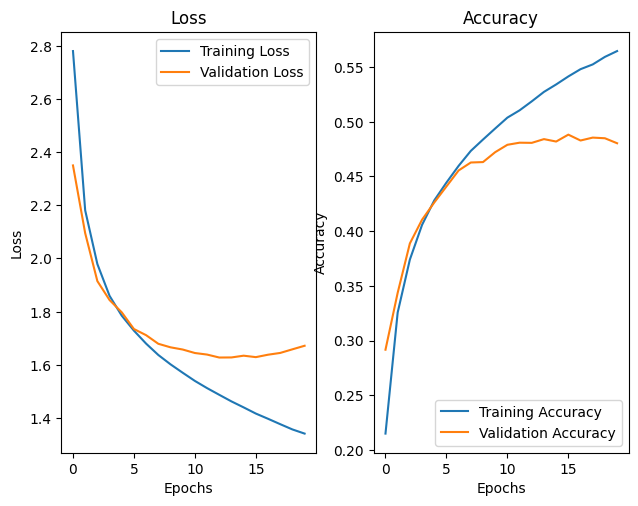

In [64]:
plot_performance(history_b)

Nel grafico che rappresenta la loss, la curva del training continua a diminuire regolamente, suggerendo che il modello apprende bene dai dati di addestramento. Mentre, la validation si stabilizza intorno a 1.6, ma mostra  un leggero aumento nelle ultime epoche suggerendo che è presente overfitting. Nel grafico dell'accuracy, il training aumenta costantemente, raggiungendo circa il 55%. La validation si stabilizza intorno al 48%.

In [65]:
score = model_b.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6599279642105103
Test accuracy 0.4838176667690277


I risultati ottenuti sono coerenti con quanto osservato nei grafici perchè la validation loss si stabilizza intorno a 1.6 e la Test loss risulta essere molto vicina. Mentre,  la validation accuracy si stabilizzava intorno allo 0.48 ed è perfettamente in linea con la test accuracy. 
Anche per questo modello si può concludere che le perfomance del modello non sono ottimali avendo un'accuratezza abbastanza bassa e inoltre dai grafici è stato osservato dell'overfitting 

I risultati delle due modalità sono molto simili tra di loro, l'approccio di una modalità non bilanciata ha dei valori leggermente migliori ma questo potrebbe variare dato che i canti vengono assegnati in modo casuale. Dato che i risultati sono simili tra di loro è stato deciso di utilizzare per i prossimi modelli il secondo approccio, quello della modalità bilanciata. 

# Tune the chunk length

## Model 3 - maxlen 50

In [66]:
maxlen = 50 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126341
ta
  mi ritrovai per una selva oscura
  che' la di
r


In [67]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126341, 50, 40)
y_train shape: (126341, 40)
x_val shape: (33982, 50, 40)
y_val shape: (33982, 40)
x_test shape: (24804, 50, 40)
y_test shape: (24804, 40)


In [68]:
model3 = Sequential()
model3.add(LSTM(128, input_shape=(maxlen, len(chars))))
model3.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model3.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model3
    )
)

In [70]:
history3 = model3.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback], 
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.1777 - loss: 3.0515

***** Epoch: 1 *****
***** starting sentence *****
lui; ma del salire
  non m'accors'io, se non com'u
*****************************
lui; ma del salire
  non m'accors'io, se non com'ua che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che ch
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1783 - loss: 3.0471 - val_accuracy: 0.2642 - val_loss: 2.4457
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3104 - loss: 2.2729

***** Epoch: 2 *****
***** starting sentence *****
no verranno a li due cozzi:
  questi resurgeranno 
**************************

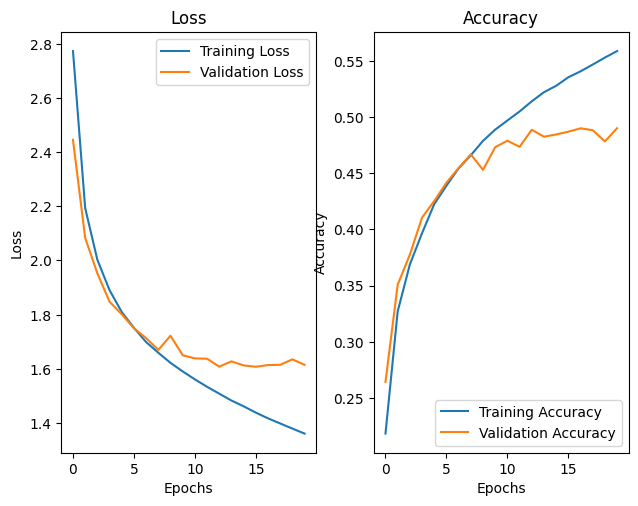

In [71]:
plot_performance(history3)

Dal grafico della loss si può notare che la curva del training continua a diminuire regolarmente, suggerendo che il modell apprende bene dai dati di addestramento, mentre la validation si stabilizza intorno a 1.6. In questo caso, rispetto al modello 2, non è presente un incremento verso la fine, però è sempre presente un chiaro divario tra training e validation indicando che è presente overfitting. 
Nel grafico dell'accuracy, il training aumenta costantemente, raggiungendo circa il 55%, mentre la validation si stabilizza introno al 48%.

In [72]:
score = model3.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.624587059020996
Test accuracy 0.4911304712295532


I risultati ottenuti sono coerenti con quanto osservato nei grafici perché la validation si stabilizza intorno a 1.6 e la Test loss risulta essere molto vicina. Mentre, la validation accuracy si stabilizzava intorno allo 0.48 ed è perfettamente in linea con la test accuracy. 

Se confrontiamo questo modello con il modello 2, possiamo notare che i risultati sono leggermente migliorati dimostrando con una leggera diminuzione della loss e un aumento di un punto percentuale dell'accuracy, però è sempre presente overfitting. 

## maxlen 20

In [73]:
maxlen = 20 # chunk length
step = 2

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  189526
i nostra vita
  mi r
i


In [74]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (189526, 20, 40)
y_train shape: (189526, 40)
x_val shape: (50988, 20, 40)
y_val shape: (50988, 40)
x_test shape: (37221, 20, 40)
y_test shape: (37221, 40)


In [75]:
model4 = Sequential()
model4.add(LSTM(128, input_shape=(maxlen, len(chars))))
model4.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model4.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model4
    )
)

In [77]:
history4 = model4.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback], 
        )

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1975 - loss: 2.8995

***** Epoch: 1 *****
***** starting sentence *****
er 'tu m'appaghe',
 
*****************************
er 'tu m'appaghe',
  costo per a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 477ms/step - accuracy: 0.1981 - loss: 2.8961 - val_accuracy: 0.3213 - val_loss: 2.1678
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3520 - loss: 2.0778

***** Epoch: 2 *****
***** starting sentence *****
e>>.

cosi` la circu
*****************************
e>>.

cosi` la circunto anter la perto manto si perto manto si perto manto si perto

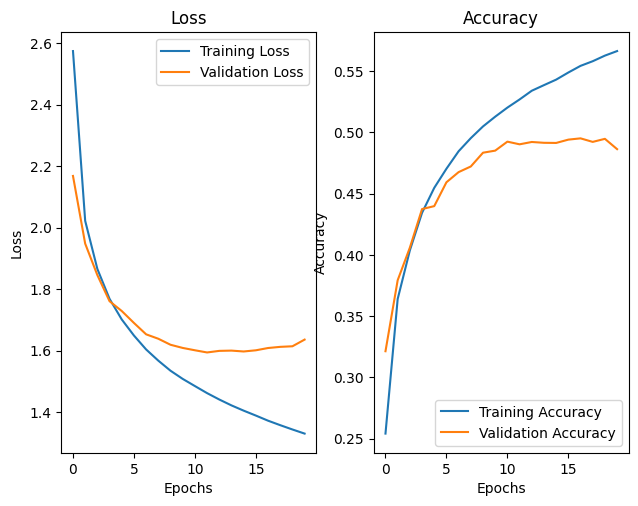

In [78]:
plot_performance(history4)

Dal grafico della loss si può osservare che la curva del training continua a diminuire regolarmente, suggerendo che il modello apprende bene dai dati di addestramento, mentre la curva della validation si stabilizza intorno a 1.6, ma mostra un aumento nelle ultime epoche, suggerendo che è presente overfitting. Nel grafico dell'accuracy, il training aumenta costantemente, raggiungendo circa il 55%, mentre la validation si stabilizza intorno a 48%. 

Questi grafici sono molto simili a quelli ottenuti dal modello 2, perchè verso le ultime epoche il divario tra training e validation aumenta. Non si nota un miglioramento. 

In [79]:
score = model4.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6248489618301392
Test accuracy 0.49020713567733765


I risultati ottenuti sono coerenti con quanto osservato nei grafici perchè la validation loss si stabilizza introno a 1.6 e la Test Loss risulta essere molto vicina. Mentre, la validation accuracy si stabilizzava intorno allo 0.48 ed è perfettamente in linea con la test accuracy. 

I risultati ottenuti con un Maxlen pari a 20 e uno step di 2 è quello che restituisce risultati migliori rispetto ai modelli visti finora. I valori sono tutti molto simili tra di loro e questi sono migliorati leggermente

## maxlen 80

In [80]:
maxlen = 80 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126331
ta
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi q
u


In [81]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126331, 80, 40)
y_train shape: (126331, 40)
x_val shape: (33972, 80, 40)
y_val shape: (33972, 40)
x_test shape: (24794, 80, 40)
y_test shape: (24794, 40)


In [82]:
model5 = Sequential()
model5.add(LSTM(128, input_shape=(maxlen, len(chars))))
model5.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model5.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model5.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model5
    )
)

In [84]:
history5 = model5.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback], 
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.1687 - loss: 3.0270

***** Epoch: 1 *****
***** starting sentence *****
 te, non mi domandi,
  che alcun altro in questa turba gaia.

tu credi 'l vero; 
*****************************
 te, non mi domandi,
  che alcun altro in questa turba gaia.

tu credi 'l vero;  che cora che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che ch
62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.1694 - loss: 3.0228 - val_accuracy: 0.2885 - val_loss: 2.3611
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.3170 - loss: 2.2439

***** Epoch: 2 *****
***** starting sentence *****
 torni a te da tu

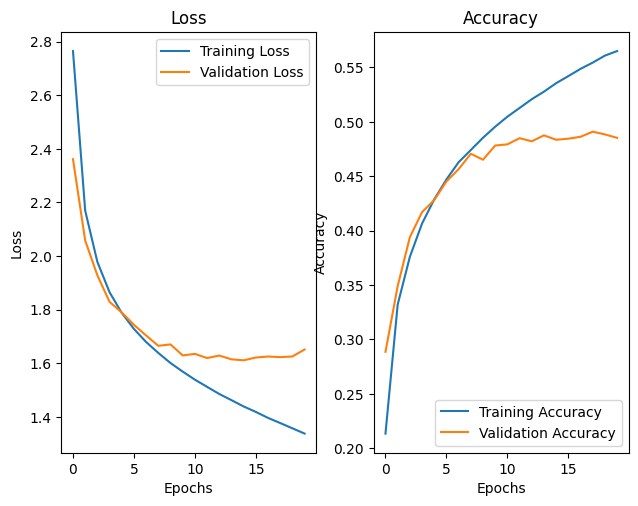

In [85]:
plot_performance(history5)

Dal grafico della loss si può notare che il training continua a diminuire regolarmente, suggerendo che il modello apprende bene dai dati di addestramento. Mentre la validation si stabilizza intorno a 1.6, ma mostra un leggero aumento nelle ultime epoche. Questo incremento rappresenta che nel modello è presente overfitting. Nel modello dell'accuracy, la curva del training aumenta costantemente, raggiungendo circa il 55%. Mentre, la validation si stabilizza intorno al 48%

In [86]:
score = model5.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.657114028930664
Test accuracy 0.4858836829662323


I risultati ottenuti sono coerenti con quanto osservato nei grafici perchè la validation loss si stabilizza intorno a 1.6 e la Test loss risulta essere molto vicina. Mentre, la validation accuracy si stabilizzava intorno allo 0.48 ed è perfettamente in linea con la test accuracy. 

Anche per questo modello le performance non sono ottimali avendo un'accuratezza abbastanza bassa e inoltre dai grafici è stato osservato dell'overfitting. 

Per questi tre modelli appena illustrati si può concludere che modificando il valore di maxlen i risultati risultano molto simili tra di loro, con leggeri miglioramti in termini di test loss e test accuracy e nei grafici una leggera diminuzione dell'overfitting, ma sempre presente. In conclusione, si può dire che il modello migliore tra quelli visti è il modello 3 (maxlen pari a 50 e step 3) perchè ha valori di test loss e test accuracy in linea con gli altri e dai grafici non è presente un incremento nelle utlime epoche

# Modify network architecture

In [104]:
maxlen = 50 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126341
ta
  mi ritrovai per una selva oscura
  che' la di
r


In [105]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126341, 50, 40)
y_train shape: (126341, 40)
x_val shape: (33982, 50, 40)
y_val shape: (33982, 40)
x_test shape: (24804, 50, 40)
y_test shape: (24804, 40)


In [106]:
from keras.layers import Dropout

model6 = Sequential()
model6.add(LSTM(128, input_shape=(maxlen, len(chars))))
#model6.add(Dropout(0.2))
model6.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model6.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model6.summary()

c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model6
    )
)

In [108]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',  # Monitora la perdita sul validation set
    patience = 3,          # Attendi 5 epoche senza miglioramento
    min_delta = 0.10  # Ripristina i pesi migliori
)

In [109]:
history6 = model6.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback, early_stopping] 
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.1685 - loss: 3.0640

***** Epoch: 1 *****
***** starting sentence *****
ietro si rauna,

io stancato e amendue incerti
  d
*****************************
ietro si rauna,

io stancato e amendue incerti
  de se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se
62/62 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.1692 - loss: 3.0594 - val_accuracy: 0.2963 - val_loss: 2.3117
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.3175 - loss: 2.2334

***** Epoch: 2 *****
***** starting sentence *****
a tutti tolle.

la` giu` trovammo una gente dipint
*************************

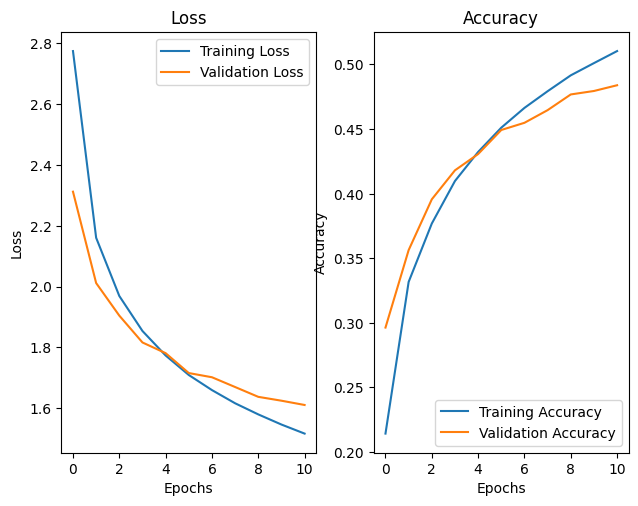

In [110]:
plot_performance(history6)

In [111]:
score = model6.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6180566549301147
Test accuracy 0.4846798777580261


## Test cava

In [112]:
maxlen = 50 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126341
ta
  mi ritrovai per una selva oscura
  che' la di
r


In [117]:
print(f"Number of unique characters: {len(chars)}")

Number of unique characters: 40


In [113]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126341, 50, 40)
y_train shape: (126341, 40)
x_val shape: (33982, 50, 40)
y_val shape: (33982, 40)
x_test shape: (24804, 50, 40)
y_test shape: (24804, 40)


In [118]:
from tensorflow.keras.layers import RepeatVector

model7 = Sequential()
model7.add(LSTM(196, input_shape=(maxlen, len(chars))))
model7.add(RepeatVector(1)) # makes output 3D for next layer
model7.add(LSTM(40))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model7.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model7.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 196)            │       185,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 196)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 40)             │        37,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,728 (873.94 KB)

 Trainable params: 223,728 (873.94 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model7
    )
)

In [120]:
history7 = model7.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback] 
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0480 - loss: 8.9640

***** Epoch: 1 *****
***** starting sentence *****
non era la calla onde saline
  lo duca mio, e io a
*****************************
non era la calla onde saline
  lo duca mio, e io aeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
62/62 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.0482 - loss: 8.9693 - val_accuracy: 0.0897 - val_loss: 10.5032
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0875 - loss: 10.3627

***** Epoch: 2 *****
***** starting sentence *****
lla angoscia
  che m'avacciava un poco ancor la le
*****************************

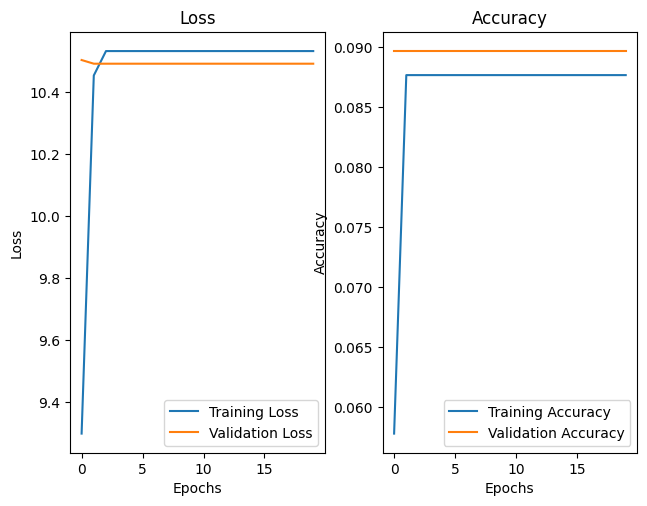

In [121]:
plot_performance(history7)

In [122]:
score = model7.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 10.486766815185547
Test accuracy 0.08361554890871048


## Another model

In [123]:
maxlen = 50 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126341
ta
  mi ritrovai per una selva oscura
  che' la di
r


In [124]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126341, 50, 40)
y_train shape: (126341, 40)
x_val shape: (33982, 50, 40)
y_val shape: (33982, 40)
x_test shape: (24804, 50, 40)
y_test shape: (24804, 40)


In [125]:
from keras.layers import Dropout

model8 = Sequential()
model8.add(LSTM(128, input_shape=(maxlen, len(chars))))
model8.add(Dropout(0.05))
model8.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model8.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
    )
model8.summary()

c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model6
    )
)

In [127]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',  # Monitora la perdita sul validation set
    patience = 3,          # Attendi 5 epoche senza miglioramento
    min_delta = 0.10  # Ripristina i pesi migliori
)

In [128]:
history8 = model8.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048, 
        epochs = 20, 
        callbacks = [print_callback] 
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.1655 - loss: 3.0543

***** Epoch: 1 *****
***** starting sentence *****
iascun e` lungo la grotta assiso>>.

allora piu` c
*****************************
iascun e` lungo la grotta assiso>>.

allora piu` che tu che la sua faccia,
  che la contra con la condi al panto spente,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra con la condi al panto,
  che la contra c
62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.1663 - loss: 3.0499 - val_accuracy: 0.2952 - val_loss: 2.3403
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.3102 - loss: 2.2697

***** Epoch: 2 *****
***** starting sentence *****
 dentro a questi termini e` ripieno
  di venenosi 
**************************

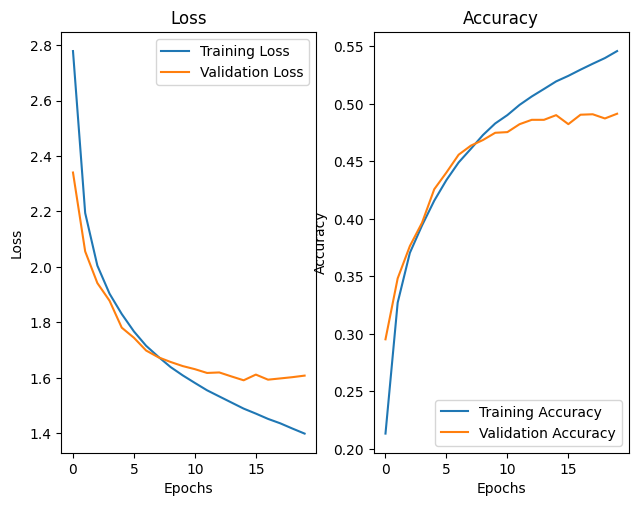

In [129]:
plot_performance(history8)

In [130]:
score = model8.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6133242845535278
Test accuracy 0.4882276952266693
